In [1]:
import pymongo
from pprint import pprint
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Set, Tuple
import functools as ft
import numpy as np
import random
from tqdm import tqdm
import spacy
nlp = spacy.load("en_core_web_sm")

In [2]:
def utc_to_dt(utc: float) -> datetime:
    """Convert a unix time to a python datetime."""
    return datetime.utcfromtimestamp(int(utc))

In [3]:
# define mongo connection
conn = pymongo.MongoClient('localhost', 27017)
db = conn["drug_pricing"]
coll = db["praw"]

In [4]:
# generate a dataframe of random samples
n_samples = 100000
samp_query = coll.aggregate([{ "$sample": {"size": n_samples} }])
samp_df = pd.DataFrame(list(samp_query))
full_df = pd.DataFrame(list(coll.find({})))

In [5]:
# format dataframe
samp_df["year"] = samp_df.time.apply(lambda x: str(x.year))
full_df["year"] = full_df.time.apply(lambda x: str(x.year))

## Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

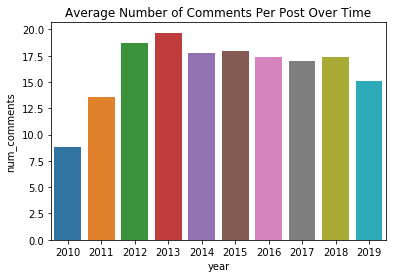

In [233]:
comm_df = full_df.loc[:,["year", "num_comments"]].dropna().groupby("year").mean().reset_index()
ax = sns.barplot(x=comm_df.year, y=comm_df.num_comments)
ax.set_title("Average Number of Comments Per Post Over Time")

## Active Number of Users on R/Opiates Over Time

In [235]:
def users_per_year(df: pd.DataFrame) -> Tuple[List[str], List[int]]:
    """
    Find the number of unique users per year in the given df.
    
    Note: assumes columns names "username" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    user_counts: List[int] = [df.loc[df.year == year, "username"].unique().shape[0] for year in years]
    return years, user_counts

Text(0.5, 1.0, 'Number of r/opiates Active Users Over Time')

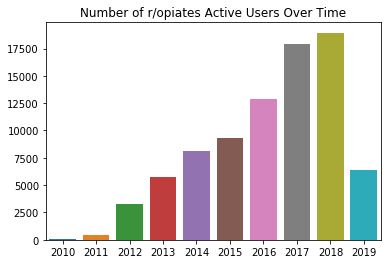

In [236]:
years, user_counts = users_per_year(full_df)
ax = sns.barplot(x=years, y=user_counts)
ax.set_title("Number of r/opiates Active Users Over Time")

## Number of Posts Over Time
### 1. Grouping with Pandas

Text(0.5, 1.0, 'Number of r/opiates Posts Over Time')

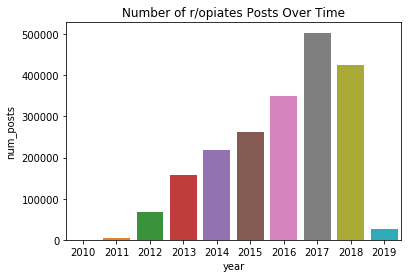

In [237]:
count_df = full_df.groupby("year").count().reset_index().loc[:, ["year", "_id"]]
count_df.columns = ["year", "num_posts"]
norm_posts: List[float] = [p / u for p, u in zip(count_df["num_posts"], user_counts)]
ax = sns.barplot(x=count_df.year, y=count_df["num_posts"])
ax.set_title("Number of r/opiates Posts Over Time")

### 2. Grouping with Mongo

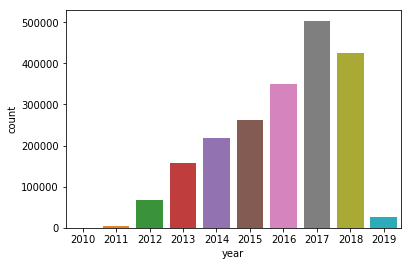

In [197]:
# group by year
query_str = { 
    "$group": { 
        "_id": { 
            "year": {"$year": "$time"}}, 
        "count": {
            "$sum": 1
        },
        "subs": {"$sum": 1}
    }
}
query = coll.aggregate([query_str])

# extract data
query_li = list(query)
years = [str(it["_id"]["year"]) for it in query_li]
counts = [it["count"] for it in query_li]

# create dataframe
df = pd.DataFrame({"year": years, "count": counts})

# plot
sns.barplot(x="year", y="count", data=df)

## Word Usage Over Time

In [241]:
def word_per_year(df: pd.DataFrame, words: List[str], user_counts: List[int]) -> pd.DataFrame:
    """
    Find the number of occurrences of the word per year in the df.
    Also returns a column with word counts normalized by active user counts.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    check_in = lambda text: 1 if len(set(words) & set(str(text).split())) > 0 else 0
    countw = lambda year: df.loc[df.year == year, "text"].apply(check_in).sum()
    word_counts: List[int] = [countw(year) for year in years]
    wc_norm: List[float] = [w / u for w, u in zip(word_counts, user_counts)]
    return pd.DataFrame({"years": years, "word_counts": word_counts, "wc_norm": wc_norm})

def append_wc(df: pd.DataFrame, words: List[List[str]], user_counts: List[int]) -> pd.DataFrame:
    """Generates a dataframe with multiple word counts for visualization."""
    wc_df = ft.reduce(lambda acc, w: acc.append(word_per_year(df, w, user_counts)), words, pd.DataFrame())
    nyear = df.year.unique().shape[0]
    word_arr = ft.reduce(lambda acc, w: acc + [w[0]] * nyear, words, [])
    wc_df["words"] = word_arr
    return wc_df

In [243]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
words = [["fentanyl", "fent"], ["heroin"]]
wc_df = append_wc(full_df, words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

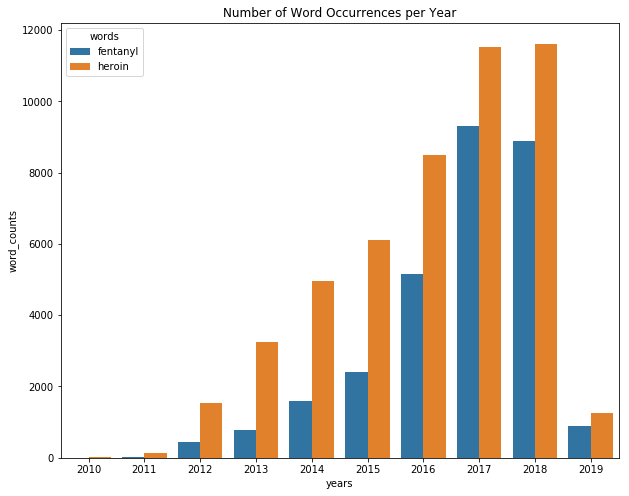

In [244]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=wc_df)
ax.set_title(f"Number of Word Occurrences per Year")

## Spacy Location Extraction

In [30]:
# process text with spacy
text = full_df.text.dropna().tolist()
n_samples = 100000
samp_text = random.sample(text, n_samples)
docs = []
for i in tqdm(range(len(samp_text))):
    docs.append(nlp(samp_text[i]))

100%|██████████| 100000/100000 [25:05<00:00, 66.40it/s]


In [31]:
# extract location entities
ents = ft.reduce(lambda acc, d: acc + list(d.ents), docs, [])
gpes = [e for e in ents if e.label_ == "GPE"]

In [32]:
# display a frequency table of GPEs
gpe_counts = pd.Series(gpes).apply(lambda x: str(x)).value_counts()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(gpe_counts)

US                                                                        421
UK                                                                        205
Canada                                                                    179
Florida                                                                   146
China                                                                     129
Valium                                                                    121
America                                                                   108
Tramadol                                                                  108
Kratom                                                                    104
Australia                                                                  97
Mexico                                                                     86
Chicago                                                                    84
California                                                      

In [40]:
("chitown" in gpe_counts or "Chitown" in gpe_counts or "chi-town" in gpe_counts or "Chi-town" in gpe_counts)

False

In [39]:
"Chicago" in gpe_counts

True

## Frequency Table

In [22]:
freq_df = pd.DataFrame(list(coll.find({})))
freq_df["year"] = freq_df.time.apply(lambda x: str(x.year))

In [27]:
freq_df = freq_df.loc[freq_df.year != "2019", :]
freq_df["Threads"] = freq_df["is_sub"].apply(lambda x: 1 if x else 0)
freq_df["Comments"] = freq_df["is_sub"].apply(lambda x: 1 if (not x) else 0)
freq_df["Totals"] = [1] * freq_df.shape[0]
count_df = freq_df.groupby("year").sum().loc[:,["Threads", "Comments", "Totals"]]

In [28]:
count_df

,Threads,Comments,Totals
year,,,
2010,42.0,359.0,401.0
2011,268.0,3675.0,3943.0
2012,3397.0,63393.0,66790.0
2013,7642.0,150380.0,158022.0
2014,11462.0,207919.0,219381.0
2015,13701.0,249263.0,262964.0
2016,18822.0,331118.0,349940.0
2017,32046.0,471529.0,503575.0
2018,65269.0,360666.0,425935.0
